##Importing Libraries 

In [0]:
import nltk, pickle, torch, torch.nn as nn, torchvision.models as models, random, matplotlib.pyplot as plt, numpy as np, os
from collections import Counter
from pycocotools.coco import COCO
from pathlib import Path
from PIL import Image
from torchvision import transforms
from torch.nn.utils.rnn import pack_padded_sequence
import torch.utils.data as data

In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
PATH = Path('data')
caption_path = PATH/'annotations/captions_train2014.json'
vocab_path = PATH/'vocab.pkl'

##Building Vocabulary

In [0]:
class vocabulary(object):
  def __init__(self):
    self.word2idx = {}
    self.idx2word = {}
    self.idx = 0
  def add_word(self,word):
    if not word in self.word2idx:
      self.word2idx[word] = self.idx
      self.idx2word[self.idx] = word
      self.idx += 1
  def __call__(self,word):
    if not word in self.word2idx:
      return self.word2idx['<unk>']
    return self.word2idx[word]
  def __len__(self):
    return len(self.word2idx)

In [0]:
def build_vocabulary(json, threshold):
  coco = COCO(json)
  counter = Counter()
  ids = coco.anns.keys()
  for i, id in enumerate(ids):
    caption = str(coco.anns[id]['caption'])
    tokens = nltk.tokenize.word_tokenize(caption.lower())
    counter.update(tokens)
    if (i+1) % 10000 == 0:
      print("[{}/{}] Tokenized the captions.".format(i+1, len(ids)))
  word_list = [word for word, cnt in counter.items() if cnt>= threshold]
  
  vocab = vocabulary()
  vocab.add_word('<pad>')
  vocab.add_word('<start>')
  vocab.add_word('<end>')
  vocab.add_word('<unk>')
  for word in word_list:
    vocab.add_word(word)
  return vocab

In [10]:
vocab = build_vocabulary(json=caption_path, threshold=4)
vocab_path = vocab_path
with open(vocab_path, 'wb') as f:
     pickle.dump(vocab, f)
print("Total vocabulary size: {}".format(len(vocab)))
print("Saved the vocabulary wrapper to '{}'".format(vocab_path))

loading annotations into memory...
Done (t=1.04s)
creating index...
index created!
[10000/414113] Tokenized the captions.
[20000/414113] Tokenized the captions.
[30000/414113] Tokenized the captions.
[40000/414113] Tokenized the captions.
[50000/414113] Tokenized the captions.
[60000/414113] Tokenized the captions.
[70000/414113] Tokenized the captions.
[80000/414113] Tokenized the captions.
[90000/414113] Tokenized the captions.
[100000/414113] Tokenized the captions.
[110000/414113] Tokenized the captions.
[120000/414113] Tokenized the captions.
[130000/414113] Tokenized the captions.
[140000/414113] Tokenized the captions.
[150000/414113] Tokenized the captions.
[160000/414113] Tokenized the captions.
[170000/414113] Tokenized the captions.
[180000/414113] Tokenized the captions.
[190000/414113] Tokenized the captions.
[200000/414113] Tokenized the captions.
[210000/414113] Tokenized the captions.
[220000/414113] Tokenized the captions.
[230000/414113] Tokenized the captions.
[24000

##Resizing images

In [0]:
def resize_image(image, size):
    return image.resize(size, Image.ANTIALIAS)
def resize_images(image_dir, output_dir, size):
    p = Path(output_dir)
    p.mkdir(parents=True, exist_ok=True)
    images = os.listdir(image_dir)
    num_images = len(images)
    for i, image in enumerate(images):
        with open(Path(image_dir)/image, 'r+b') as f:
            with Image.open(f) as img:
                img = resize_image(img, size)
                img.save(Path(output_dir)/image, img.format)
        if (i+1)%10000==0:
            print(f'[{i+1}/{num_images}] resized and saved into {output_dir}')

In [0]:
image_dir = Path('data/train2014')
output_dir = Path('data/resized2014')
image_size = [256, 256]

In [13]:
resize_images(image_dir, output_dir, image_size)

[10000/82783] resized and saved into data/resized2014
[20000/82783] resized and saved into data/resized2014
[30000/82783] resized and saved into data/resized2014
[40000/82783] resized and saved into data/resized2014
[50000/82783] resized and saved into data/resized2014
[60000/82783] resized and saved into data/resized2014
[70000/82783] resized and saved into data/resized2014
[80000/82783] resized and saved into data/resized2014


##Dataset loader

In [0]:
class Dataset(data.Dataset):
  def __init__(self, root, json, vocab, transform=None):
    self.root = root
    self.coco = COCO(json)
    self.ids = list(self.coco.anns.keys())
    self.vocab = vocab
    self.transform = transform
  def __getitem__(self, index):
    coco = self.coco
    vocab = self.vocab
    ann_id = self.ids[index]
    caption = coco.anns[ann_id]['caption']
    img_id = coco.anns[ann_id]['image_id']
    path = coco.loadImgs(img_id)[0]['file_name']
    image = Image.open(Path(self.root)/path).convert('RGB')
    if self.transform is not None:
        image = self.transform(image)
    tokens = nltk.tokenize.word_tokenize(str(caption).lower())
    caption = []
    caption.append(vocab('<start>'))
    caption.extend([vocab(token) for token in tokens])
    caption.append(vocab('<end>'))
    target = torch.Tensor(caption)
    return image, target
  def __len__(self):
     return len(self.ids)

In [0]:
def collate_fn(data):
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)
    images = torch.stack(images, 0)
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]
    return images, targets, lengths

In [0]:
def get_loader(root, json, vocab, transform, batch_size, shuffle, num_workers):
    coco = Dataset(root=root, json=json, vocab=vocab, transform=transform)
    dl = torch.utils.data.DataLoader(dataset=coco, batch_size=batch_size, shuffle=shuffle, 
                                     num_workers=num_workers, collate_fn=collate_fn)
    return dl

##Encoder

In [0]:
class Encoder(nn.Module):
    def __init__(self, embed_size):
        super(Encoder, self).__init__()
        resnet = models.resnet34(pretrained=True)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features

##Decoder

In [0]:
class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_len=20):
        super(Decoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_len = max_seq_len
    def forward(self, features, captions, lengths):
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        pack = pack_padded_sequence(embeddings, lengths, batch_first=True)
        hiddens, _ = self.lstm(pack)
        outputs = self.linear(hiddens[0])
        return outputs
    def sample(self, features, states=None):
        sample_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seq_len):
            hiddens, states = self.lstm(inputs, states)
            outputs = self.linear(hiddens.squeeze(1))
            _, predicted = outputs.max(1)
            sample_ids.append(predicted)
            inputs = self.embed(predicted)
            inputs = inputs.unsqueeze(1)
        sample_ids = torch.stack(sample_ids, 1)
        return sample_ids

In [20]:
!export CUDA_LAUNCH_BLOCKING=1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

##Specifying Loss and Optimisation

In [0]:
PATH = Path('data')
model_path = Path('models')
model_path.mkdir(parents=True, exist_ok=True)
crop_size = 224
caption_path = PATH/'annotations/captions_train2014.json'
vocab_path = PATH/'vocab.pkl'
image_dir = Path('data/resized2014')
log_step = 100
save_step = 1000
embed_size = 256
hidden_size = 512
num_layers = 1
num_epochs = 2
batch_size = 64
num_workers = 2
learning_rate = 0.01

In [0]:
transform = transforms.Compose([
    transforms.RandomCrop(crop_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))
])

In [23]:
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)
train_dl = get_loader(image_dir, caption_path, vocab, transform, batch_size, shuffle=True, num_workers=num_workers)

loading annotations into memory...
Done (t=1.04s)
creating index...
index created!


In [0]:
encoder = Encoder(embed_size).to(device)
decoder = Decoder(embed_size, hidden_size, len(vocab), num_layers).to(device)

In [0]:

criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)

##Training

In [26]:
total_steps = len(train_dl)
print(total_steps)
for epoch in range(num_epochs):
    for i, (images, captions, lengths) in enumerate(train_dl):
        images = images.to(device)
        captions = captions.to(device)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
        features = encoder(images)
        outputs = decoder(features, captions, lengths)
        loss = criterion(outputs, targets)
        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i%log_step==0:
            print(f'Epoch [{epoch}/{num_epochs}], Step [{i}/{total_steps}], Loss: {loss.item()}, Perplexity: {np.exp(loss.item())}')
        if i%save_step==0:
            torch.save(decoder.state_dict(), Path(model_path)/'decoder-{}-{}.ckpt'.format(epoch+1, i+1))
            torch.save(encoder.state_dict(), Path(model_path)/'encoder-{}-{}.ckpt'.format(epoch+1, i+1))

6471
Epoch [0/2], Step [0/6471], Loss: 9.202041625976562, Perplexity: 9917.35593535613
Epoch [0/2], Step [100/6471], Loss: 3.506998300552368, Perplexity: 33.3480166741376
Epoch [0/2], Step [200/6471], Loss: 3.1489198207855225, Perplexity: 23.310871058244075
Epoch [0/2], Step [300/6471], Loss: 2.899552822113037, Perplexity: 18.166020110372887
Epoch [0/2], Step [400/6471], Loss: 2.7712225914001465, Perplexity: 15.978156830276925
Epoch [0/2], Step [500/6471], Loss: 2.96989369392395, Perplexity: 19.489847596679198
Epoch [0/2], Step [600/6471], Loss: 2.7186191082000732, Perplexity: 15.159374329176886
Epoch [0/2], Step [700/6471], Loss: 3.036081314086914, Perplexity: 20.823482454953645
Epoch [0/2], Step [800/6471], Loss: 3.035235643386841, Perplexity: 20.805880089919224
Epoch [0/2], Step [900/6471], Loss: 2.8432328701019287, Perplexity: 17.171188122561702
Epoch [0/2], Step [1000/6471], Loss: 2.866032361984253, Perplexity: 17.56717953483189
Epoch [0/2], Step [1100/6471], Loss: 2.5051491260528

In [0]:
torch.save(decoder.state_dict(), Path(model_path)/'decoder-2-6741.ckpt')
torch.save(encoder.state_dict(), Path(model_path)/'encoder-2-6741.ckpt')

In [0]:

encoder_path = Path('models/encoder-2-6741.ckpt')
decoder_path = Path('models/decoder-2-6741.ckpt')

In [0]:
image_test_path = Path(PATH)/'val2014'
image_test_list = [image for image in Path(image_test_path).iterdir()]
image_to_test = random.choice(image_test_list)

In [0]:
def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.LANCZOS)
    if transform is not None:
        image = transform(image).unsqueeze(0)
    return image

In [0]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))
])

In [0]:
encoder = Encoder(embed_size).eval()
decoder = Decoder(embed_size, hidden_size, len(vocab), num_layers)
encoder = encoder.to(device)
decoder = decoder.to(device)

In [0]:
encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path))

In [0]:
image = load_image(image_to_test, test_transform)
image_tensor = image.to(device)

In [0]:

feature = encoder(image_tensor)
sample_ids = decoder.sample(feature)
sample_ids = sample_ids[0].cpu().numpy()

In [0]:

sample_caption = []
for word_id in sample_ids:
    word = vocab.idx2word[word_id]
    sample_caption.append(word)
    if word=='<end>':
        break
sentence = ' '.join(sample_caption)

<start> a train engine carrying a train on the tracks . <end>


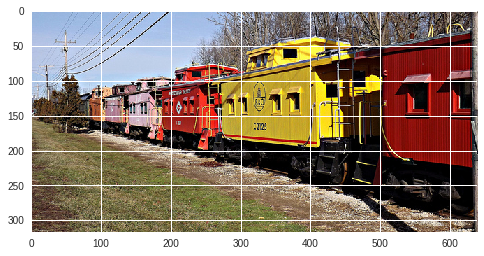

In [39]:
print(sentence)
image = Image.open(image_to_test)
plt.imshow(np.asarray(image))